# Лабораторная работа по машинному обучению №2

## Выполнил студент группы 15-В-1   Богатов Егор
### Вариант №5

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import interp
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (auc, roc_curve, 
                             precision_recall_curve, 
                             average_precision_score)

from sklearn import datasets
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
sns.set_style('whitegrid')
df = pd.read_csv('zoo.csv')

### 1) Изучить набор данных. Создать описание набора данных на русском языке. Описать признаки, используемые в наборе данных (включить полученные описания в отчёт).

Этот набор данных состоит из 101 жиаотного из зоопарка. 16 показателей с различными чертами для описания животных. Существует 7 типов: млекопитающие, птицы, рептилии, рыбы, амфибии, жуки и беспозвоночные.
Атрибутивная информация:
* animal_name - индивидуальное имя для каждого животного
* Волосы
* Перья
* Яйца
* Молоко
* Воздушный
* Водный
* Хищник
* Зубастый
* Позвоночный
* Дышащий
* Ядовитый: Будем распазновать какое животное ядовитое , а какое не ядовитое
* Плавники
* Количество ног( область значений:{0,2,4,5,6,8})
* Хвостатые
* Домашние
* Размером с кота

In [5]:
df.drop('animal_name', axis=1, inplace=True)
print('dataset size: ', df.shape)
df.count()

dataset size:  (101, 17)


hair          101
feathers      101
eggs          101
milk          101
airborne      101
aquatic       101
predator      101
toothed       101
backbone      101
breathes      101
venomous      101
fins          101
legs          101
tail          101
domestic      101
catsize       101
class_type    101
dtype: int64

### 2) Удалите дубликаты строк в наборе данных

In [6]:
df = df.drop_duplicates()
print('dataset size', df.shape)
df.count()

dataset size (59, 17)


hair          59
feathers      59
eggs          59
milk          59
airborne      59
aquatic       59
predator      59
toothed       59
backbone      59
breathes      59
venomous      59
fins          59
legs          59
tail          59
domestic      59
catsize       59
class_type    59
dtype: int64

In [7]:
df.head()

hair  feathers  eggs  milk  airborne  aquatic  predator  toothed  backbone  \
0     1         0     0     1         0        0         1        1         1   
1     1         0     0     1         0        0         0        1         1   
2     0         0     1     0         0        1         1        1         1   
4     1         0     0     1         0        0         1        1         1   
6     1         0     0     1         0        0         0        1         1   

   breathes  venomous  fins  legs  tail  domestic  catsize  class_type  
0         1         0     0     4     0         0        1           1  
1         1         0     0     4     1         0        1           1  
2         0         0     1     0     1         0        0           4  
4         1         0     0     4     1         0        1           1  
6         1         0     0     4     1         1        1           1

### 3) Оцените сбалансированность данных по классам (постройте гистограмму). Используйте полученную информацию при выборе метрики оценки качества классификации (PR или ROC кривая)

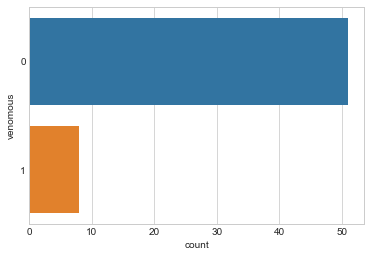

In [8]:
sns.countplot(data=df, y='venomous')
plt.show()

Классы не сбалансированы

### 4)  Выполните масштабирование количественных признаков

In [9]:
df['class_type'] = df['class_type'].apply(lambda x: str(x))

numerical_columns = [i for i in df.columns if df[i].dtype.name != 'object']
categorial_columns = [i for i in df.columns if df[i].dtype.name == 'object']

print('numerical: ', numerical_columns)
print('categorial: ', categorial_columns)

numerical:  ['hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'predator', 'toothed', 'backbone', 'breathes', 'venomous', 'fins', 'legs', 'tail', 'domestic', 'catsize']
categorial:  ['class_type']


In [10]:
scaler = MinMaxScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
df.head()

hair  feathers  eggs  milk  airborne  aquatic  predator  toothed  backbone  \
0   1.0       0.0   0.0   1.0       0.0      0.0       1.0      1.0       1.0   
1   1.0       0.0   0.0   1.0       0.0      0.0       0.0      1.0       1.0   
2   0.0       0.0   1.0   0.0       0.0      1.0       1.0      1.0       1.0   
4   1.0       0.0   0.0   1.0       0.0      0.0       1.0      1.0       1.0   
6   1.0       0.0   0.0   1.0       0.0      0.0       0.0      1.0       1.0   

   breathes  venomous  fins  legs  tail  domestic  catsize class_type  
0       1.0       0.0   0.0   0.5   0.0       0.0      1.0          1  
1       1.0       0.0   0.0   0.5   1.0       0.0      1.0          1  
2       0.0       0.0   1.0   0.0   1.0       0.0      0.0          4  
4       1.0       0.0   0.0   0.5   1.0       0.0      1.0          1  
6       1.0       0.0   0.0   0.5   1.0       1.0      1.0          1

### 5) Выполните замену категориальных признаков

In [11]:
binary_columns = [i for i in categorial_columns if len(df[i].unique()) == 2]
nonbinary_columns = [i for i in categorial_columns if len(df[i].unique()) > 2]

# для бинарных заменим значения на 1 и 0
for col in binary_columns:
    for i, unic_item in enumerate(df[col].unique()):
        df[col] = df[col].replace(to_replace=[unic_item], value=[i])
        
# для не бинарых применим dummy-кодирование
df_nonbinary = pd.get_dummies(df[nonbinary_columns])
df.drop(nonbinary_columns, axis=1, inplace=True)
df = pd.concat([df_nonbinary, df] , axis=1)

print(df.shape)
df.head()

(59, 23)


class_type_1  class_type_2  class_type_3  class_type_4  class_type_5  \
0             1             0             0             0             0   
1             1             0             0             0             0   
2             0             0             0             1             0   
4             1             0             0             0             0   
6             1             0             0             0             0   

   class_type_6  class_type_7  hair  feathers  eggs   ...     predator  \
0             0             0   1.0       0.0   0.0   ...          1.0   
1             0             0   1.0       0.0   0.0   ...          0.0   
2             0             0   0.0       0.0   1.0   ...          1.0   
4             0             0   1.0       0.0   0.0   ...          1.0   
6             0             0   1.0       0.0   0.0   ...          0.0   

   toothed  backbone  breathes  venomous  fins  legs  tail  domestic  catsize  
0      1.0       1.0       1.0       0.0   0.0   0.5   0.0       0.0      1.0  
1      1.0       1.0       1.0       0.0   0.0   0.5   1.0       0.0      1.0  
2      1.0       1.0       0.0       0.0   1.0   0.0   1.0       0.0      0.0  
4      1.0       1.0       1.0       0.0   0.0   0.5   1.0       0.0      1.0  
6      1.0       1.0       1.0       0.0   0.0   0.5   1.0       1.0      1.0  

[5 rows x 23 columns]

In [12]:
label_encoder = LabelEncoder()

mapped_education = pd.Series(label_encoder.fit_transform(df['venomous']))
mapped_education.value_counts().plot.barh()
print(dict(enumerate(label_encoder.classes_)))

{0: 0.0, 1: 1.0}


### 6) Оцените корреляцию между признаков и удалите те признаки, которые коррелируют с наибольшим числом других (удалять признаки нужно только для линейных методов классификации)

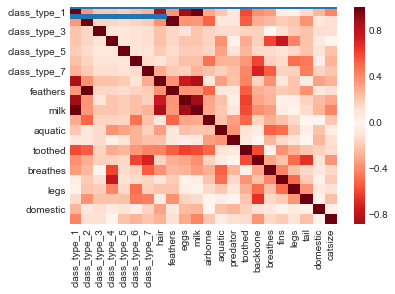

In [10]:
corr_matrix = df.drop('venomous', axis=1).corr()
colors = sns.color_palette("Reds_r", n_colors=100)
colors += sns.color_palette("Reds", n_colors=100)
sns.heatmap(corr_matrix, cmap=colors, center=0);
plt.show()

### 7)   Заполните пропущенные значения в данных

In [11]:
print('dataset size', df.shape)
df.count()

dataset size (59, 23)


class_type_1    59
class_type_2    59
class_type_3    59
class_type_4    59
class_type_5    59
class_type_6    59
class_type_7    59
hair            59
feathers        59
eggs            59
milk            59
airborne        59
aquatic         59
predator        59
toothed         59
backbone        59
breathes        59
venomous        59
fins            59
legs            59
tail            59
domestic        59
catsize         59
dtype: int64

In [12]:

dtc = DecisionTreeClassifier()
X, y = df.drop('venomous', axis=1), df['venomous']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

# Дерево
params = {'max_depth': list(range(1,12)), 'max_features': list(range(1,12))}

dtc_grid = GridSearchCV(dtc, params)
dtc_grid.fit(X_train, y_train)

best_features = dtc_grid.best_estimator_.max_features
best_depth = dtc_grid.best_estimator_.max_depth
best_score = dtc_grid.best_score_
print('best train score:', best_score, 
      '\t at features number:', best_features,
      '\t at depth:', best_depth)
dtc = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features)
dtc.fit(X_train, y_train)
best_score  = np.mean(y_test == dtc.predict(X_test))
print('test score: ', best_score)

best train score: 0.9024390243902439 	 at features number: 5 	 at depth: 3
test score:  0.666666666667


In [13]:
knn = KNeighborsClassifier()
df1 = df.copy()
params = {'n_neighbors': list(range(1, 20))}
knn_grid = GridSearchCV(knn, params)
knn_grid.fit(X_train, y_train)
best_num = knn_grid.best_estimator_.n_neighbors
best_score = knn_grid.best_score_

print('best train score: ', best_score,
      '\t at neighbors number: ', best_num)

best train score:  0.8780487804878049 	 at neighbors number:  2


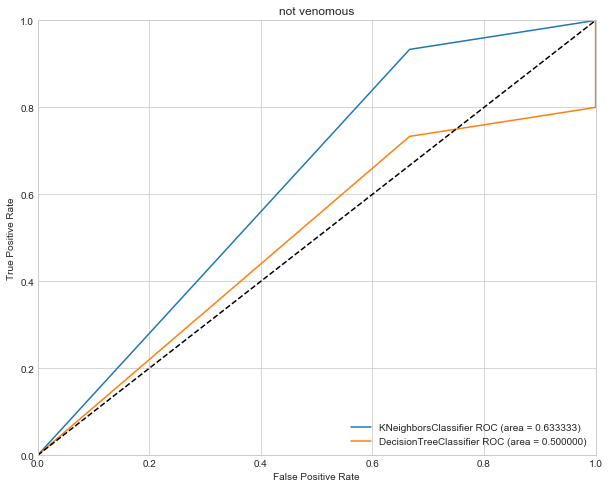

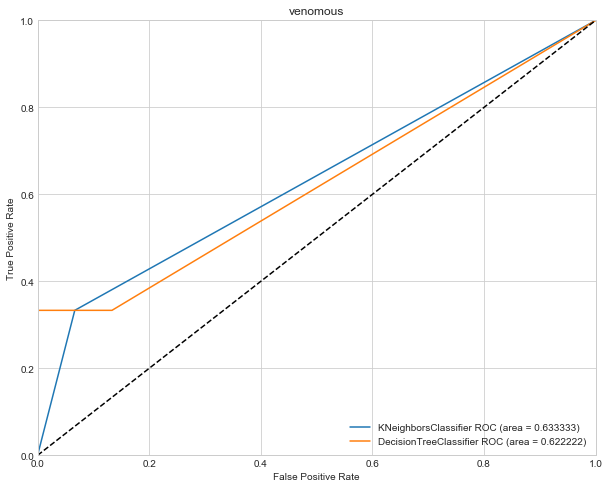

In [14]:
plt.figure(figsize=(10,8))
# K соседей
knn = KNeighborsClassifier ( n_neighbors =best_num)
probas_knn0 = knn.fit(X_train, y_train).predict_proba (X_test)
tpr, fpr, thresholds = roc_curve(y_test, probas_knn0[:,0])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('KNeighborsClassifier', roc_auc)) 

# решающее дерево
dtc = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features)
probas_dtc0 = dtc.fit(X_train, y_train).predict_proba (X_test)
tpr, fpr, thresholds = roc_curve(y_test, probas_dtc0[:,0])
roc_auc  = auc (fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('DecisionTreeClassifier', roc_auc))   

# вывод графика
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4, fontsize='medium')
plt.title('not venomous')
plt.show()


plt.figure(figsize=(10,8))
# K соседей
knn = KNeighborsClassifier( n_neighbors = best_num)
probas_knn1 = knn.fit(X_train, y_train).predict_proba (X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_knn1[:,1])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('KNeighborsClassifier', roc_auc)) 
# решающее дерево
dtc = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features)
probas_dtc1 = dtc.fit(X_train, y_train).predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_dtc1[:,1])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('DecisionTreeClassifier', roc_auc))   
# вывод графика
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4, fontsize='medium')
plt.title('venomous')
plt.show()

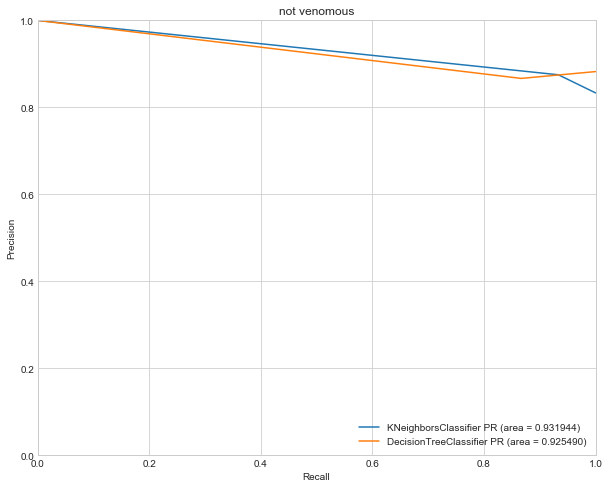

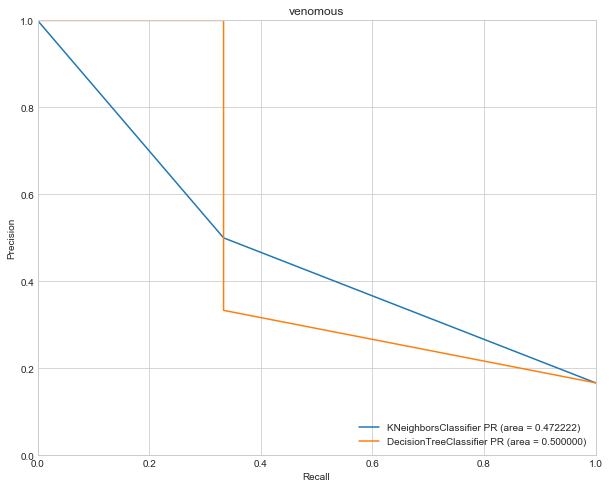

In [15]:
plt.figure(figsize=(10,8))
y_test_invers = []
for i, y in enumerate(y_test.reset_index(drop=True)):
    y_test_invers.append(1-y)
# K соседей
precision, recall, thresholds = precision_recall_curve(y_test_invers, probas_knn1[:,0])
aps_knn1 = average_precision_score(y_test_invers,probas_knn1[:,0])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('KNeighborsClassifier', aps_knn1)) 
# решающее дерево
precision, recall, thresholds = precision_recall_curve(y_test_invers, probas_dtc1[:,0])
aps_dtc1 = average_precision_score(y_test_invers,probas_dtc1[:,0])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('DecisionTreeClassifier',  aps_dtc1)) 
# вывод графика
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc=4, fontsize='medium')
plt.title('not venomous')
plt.show()


plt.figure(figsize=(10,8))
# K соседей
precision, recall, thresholds = precision_recall_curve(y_test, probas_knn0[:,1])
aps_knn0 = average_precision_score(y_test,probas_knn0[:,1])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('KNeighborsClassifier', aps_knn0)) 
# решающее дерево
precision, recall, thresholds = precision_recall_curve(y_test, probas_dtc1[:,1])
aps_dtc1 = average_precision_score(y_test,probas_dtc1[:,1])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('DecisionTreeClassifier',  aps_dtc1)) 
# вывод графика
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc=4, fontsize='medium')
plt.title('venomous')
plt.show()

### 9)	Сравните кривые для классификаторов, указанных в задании, сделайте выводы
Не удалось обучить классификаторы, так как не было достаточно данных.